In [1]:
# this file will:
    #1. load data
    #2. data augmentation
    #3. preprocess (scaling on label)
    #4. training the network on training data(use DL notebook from w4)
    #5. test (use DL notebook from w4)

In [49]:
# Import cell
import torch
import torch.nn as nn
import math
import numpy as np
from collections import OrderedDict

import torchvision.transforms as transforms
import torchvision
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns

# image loading
import os
from PIL import Image

# training process
from sklearn import model_selection

import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim

from sklearn import metrics

import random #for data shuffling in list

#torch.optim.lr_scheduler

<module 'torch.optim.lr_scheduler' from 'C:\\Users\\Lenovo\\Anaconda3\\lib\\site-packages\\torch\\optim\\lr_scheduler.py'>

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
################## DATA LOADERS ###############
def read_img(root, filedir, transform=None):
    # Data loading
    with open(filedir, 'r') as f:
        lines = f.readlines()  
    output = []    
    for line in lines:
        linesplit = line.split('\n')[0].split(' ')
        #print(linesplit)
        addr = linesplit[0]
        target = torch.Tensor([float(linesplit[1])])
        img = Image.open(os.path.join(root, addr)).convert('RGB')

        if transform is not None:
            img = transform(img)
        
        output.append([img, target])

    return output


################## DATA ANALYSIS ###############
def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()
        
################## PERFORMANCE ANALYSIS ###############      
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

In [56]:
################## AlexNet ##################
def bn_relu(inplanes):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True))

def bn_relu_pool(inplanes, kernel_size=3, stride=2):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=kernel_size, stride=stride))

class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, bias=False)
        self.relu_pool1 = bn_relu_pool(inplanes=96)
        self.conv2 = nn.Conv2d(96, 192, kernel_size=5, padding=2, groups=2, bias=False)
        self.relu_pool2 = bn_relu_pool(inplanes=192)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu3 = bn_relu(inplanes=384)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu4 = bn_relu(inplanes=384)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu_pool5 = bn_relu_pool(inplanes=256)
        # classifier
        self.conv6 = nn.Conv2d(256, 256, kernel_size=5, groups=2, bias=False)
        self.relu6 = bn_relu(inplanes=256)
        self.conv7 = nn.Conv2d(256, num_classes, kernel_size=1, bias=False)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.4)
        
        # Batchnorm
        self.batchnorm = nn.BatchNorm2d(num_features=256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.relu_pool1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.relu_pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu_pool5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        # x = self.batchnorm(x)
        x = self.conv7(x)
        x = x.view(x.size(0), -1)
        return x

In [57]:
# Scaling of data
#file_in = './data/1/morph_all_label.txt'
file_in = 'image_label_mapping.txt'
mylines = []                             # Declare an empty list named mylines.
with open(file_in, 'rt') as myfile: # Open lorem.txt for reading text data.
    for myline in myfile:                # For each line, stored as myline,
        mylines.append(float(myline.split()[1]))       # add its contents to mylines.

min_val = min(mylines)
max_val = max(mylines)
lower_scale = 0
upper_scale = 4

for i in range(len(mylines)):
    mylines[i] = int(np.round(((upper_scale-lower_scale)*((mylines[i]-min_val)/(max_val-min_val)))+lower_scale))
    
print(mylines.count(0))
print(mylines.count(1))
print(mylines.count(2))
print(mylines.count(3))
print(mylines.count(4))

392
700
1120
1288
476


In [58]:
# Storing scaled data to images
file_out = 'image_label_mapping_scaled.txt'

cntr = 0
with open(file_in, 'r') as f_in:
    with open(file_out, 'w') as f_out:
        for line in f_in:
            image_name = line.split()[0] + ' '
            rating = mylines[cntr]
            
            f_out.write(image_name+str(rating)+'\n')
            cntr+=1

In [59]:
#def main():
# net definition 
net = AlexNet()
device = torch.device('cpu')  # use cuda or cpu
net.to(device)

# evaluate
net.eval()

root = 'C:/Users/Lenovo/Documents/AdvancedProject/NeuralNetwork/data/dataset'
valdir = 'image_label_mapping_scaled.txt'

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])  
data = read_img(root, valdir, transform=transform)


In [60]:
for i in range(len(data)):
    data[i][1] = int(data[i][1].numpy()[0])

In [61]:
for i, d in enumerate(data):
    data[i] = tuple(d)

In [62]:
random.shuffle(data)

In [63]:
train_count = int(0.8*len(data))
train_count

3180

In [64]:
# Train test split, we can also use tf.split() but it doesn't support percentage split??
train_set = data[:train_count]
test_set = data[train_count:len(data)]

In [65]:
type(train_set[0][0])

torch.Tensor

In [66]:
len(train_set)

3180

In [67]:
type(test_set[0][0])

torch.Tensor

In [68]:
batch_size = 32 # try this out for training

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

In [69]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = 5
classes = list(range(5))
classes

Training data
Number of points: 3180
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])

Test data
Number of points: 796
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])


[0, 1, 2, 3, 4]

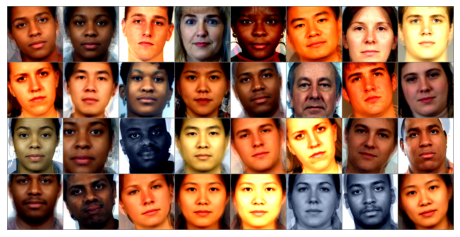

tensor([4, 4, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 4, 1, 2, 2, 2, 3, 1, 3, 3, 0, 1, 1,
        3, 0, 3, 3, 3, 2, 2, 4])

In [70]:
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))
labels

In [71]:
# Define a loss function

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [72]:
# Test the forward pass with dummy data
out = net(torch.randn(2, 3, 224, 224, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 5])
Output logits:
[[-0.00585465 -0.01869274 -0.00464663  0.00141094 -0.00955606]
 [-0.00671692 -0.02084012 -0.00184655  0.00208408 -0.01211633]]
Output probabilities:
[[0.20031852 0.19776325 0.20056064 0.20177925 0.19957843]
 [0.20022774 0.19741975 0.20120528 0.20199771 0.19914953]]


In [73]:
num_epochs = 100
validation_every_steps = 100

step = 0
net.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    print(epoch)
    train_accuracies_batches = []
    print(len(train_loader))
    for inputs, targets in train_loader:
        #print('hér')
        inputs, targets = inputs.to(device), targets.to(device)
        
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!

        # Forward
        output = net(inputs)
        loss = loss_fn(output, targets)   
        
        # backward
        loss.backward()

        # optimize
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                net.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")
            
    #scheduler.step()

print("Finished training.")

0
100
Step 100     training accuracy: 0.4119791666666666
             test accuracy: 0.3228643216080402
1
100
Step 200     training accuracy: 0.5273958333333334
             test accuracy: 0.3228643216080402
2
100
Step 300     training accuracy: 0.6013541666666666
             test accuracy: 0.3379396984924623
3
100
Step 400     training accuracy: 0.6430208333333333
             test accuracy: 0.39824120603015073
4
100
Step 500     training accuracy: 0.6936458333333333
             test accuracy: 0.38944723618090454
5
100
Step 600     training accuracy: 0.7367708333333333
             test accuracy: 0.3015075376884422
6
100
Step 700     training accuracy: 0.7591666666666668
             test accuracy: 0.36055276381909546
7
100
Step 800     training accuracy: 0.7940625
             test accuracy: 0.3178391959798995
8
100
Step 900     training accuracy: 0.830625
             test accuracy: 0.36055276381909546
9
100
Step 1000    training accuracy: 0.8351041666666668
             test accu

Step 8400    training accuracy: 0.993125
             test accuracy: 0.4108040201005025
84
100
Step 8500    training accuracy: 0.99125
             test accuracy: 0.43844221105527637
85
100
Step 8600    training accuracy: 0.9909375
             test accuracy: 0.34045226130653267
86
100
Step 8700    training accuracy: 0.9934375
             test accuracy: 0.35050251256281406
87
100
Step 8800    training accuracy: 0.9915625
             test accuracy: 0.45979899497487436
88
100
Step 8900    training accuracy: 0.9938541666666667
             test accuracy: 0.42839195979899497
89
100
Step 9000    training accuracy: 0.9940625
             test accuracy: 0.3379396984924623
90
100
Step 9100    training accuracy: 0.995625
             test accuracy: 0.4321608040201005
91
100
Step 9200    training accuracy: 0.994375
             test accuracy: 0.36055276381909546
92
100
Step 9300    training accuracy: 0.99375
             test accuracy: 0.314070351758794
93
100
Step 9400    training accuracy: 0

In [74]:
torch.save(net.state_dict(), './pytorch-models/cnn_SGD_DropOut.pth')

In [75]:
valid_accuracies

[0.3228643216080402,
 0.3228643216080402,
 0.3379396984924623,
 0.39824120603015073,
 0.38944723618090454,
 0.3015075376884422,
 0.36055276381909546,
 0.3178391959798995,
 0.36055276381909546,
 0.3793969849246231,
 0.4020100502512563,
 0.3542713567839196,
 0.3530150753768844,
 0.3341708542713568,
 0.35678391959798994,
 0.3844221105527638,
 0.36683417085427134,
 0.3756281407035176,
 0.3844221105527638,
 0.42085427135678394,
 0.3442211055276382,
 0.41708542713567837,
 0.40326633165829145,
 0.36432160804020103,
 0.34045226130653267,
 0.35050251256281406,
 0.3693467336683417,
 0.3869346733668342,
 0.33040201005025127,
 0.41959798994974873,
 0.4082914572864322,
 0.3555276381909548,
 0.3442211055276382,
 0.4334170854271357,
 0.3391959798994975,
 0.39949748743718594,
 0.37814070351758794,
 0.44597989949748745,
 0.435929648241206,
 0.44095477386934673,
 0.38190954773869346,
 0.39949748743718594,
 0.4396984924623116,
 0.4271356783919598,
 0.435929648241206,
 0.4535175879396985,
 0.4484924623115

In [76]:
train_accuracies

[0.4119791666666666,
 0.5273958333333334,
 0.6013541666666666,
 0.6430208333333333,
 0.6936458333333333,
 0.7367708333333333,
 0.7591666666666668,
 0.7940625,
 0.830625,
 0.8351041666666668,
 0.8665625,
 0.8754166666666667,
 0.8841666666666668,
 0.9040625,
 0.9191666666666667,
 0.9207291666666667,
 0.9261458333333333,
 0.9291666666666667,
 0.94875,
 0.9388541666666668,
 0.9391666666666667,
 0.9567708333333332,
 0.96,
 0.9578125,
 0.9634375,
 0.959375,
 0.968125,
 0.97375,
 0.968125,
 0.973125,
 0.9738541666666667,
 0.9666666666666667,
 0.975625,
 0.9785416666666668,
 0.9760416666666667,
 0.9782291666666667,
 0.9779166666666668,
 0.9784375,
 0.9815625,
 0.9815625,
 0.979375,
 0.9797916666666667,
 0.9791666666666667,
 0.9878125,
 0.985,
 0.984375,
 0.9839583333333333,
 0.980625,
 0.985625,
 0.988125,
 0.9829166666666667,
 0.984375,
 0.988125,
 0.9822916666666667,
 0.9865625,
 0.9827083333333333,
 0.98375,
 0.9890625,
 0.99125,
 0.9896875,
 0.9914583333333333,
 0.9879166666666667,
 0.9865

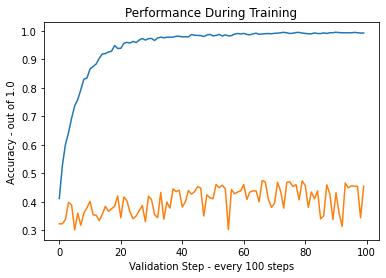

In [77]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_accuracies)),train_accuracies, label = 'Train Accuracy')
plt.plot(range(len(train_accuracies)),valid_accuracies, label = 'Test Accuracy')
plt.xlabel('Validation Step - every 100 steps')
plt.ylabel('Accuracy - out of 1.0')
plt.title("Performance During Training")
plt.savefig('train_test_acc_100epoch_SGD_DropOut.jpg')
plt.show()

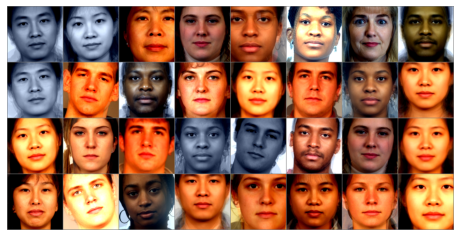

    TRUE        PREDICTED
-----------------------------
      3             3      
      3             3      
      2             2      
      2             2      
      4             4      
      2             2      
      1             1      
      2             2      
      3             3      
      0             0      
      2             2      
      1             1      
      3             3      
      2             2      
      3             3      
      3             3      
      3             3      
      1             1      
      2             2      
      3             3      
      1             1      
      2             2      
      2             2      
      4             4      
      0             0      
      2             2      
      3             3      
      3             3      
      2             2      
      2             2      
      3             3      
      3             4      


In [78]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")

In [79]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    net.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = net(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]
        
        print(target, predictions)
        
        if compute_confusion_matrix(targets, predictions, 'true').shape == (5, 5):
        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
            test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
            confusion_matrix += compute_confusion_matrix(targets, predictions, 'true')

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    net.train()

tensor(3) tensor([3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 0, 2, 2, 2, 2, 3, 3, 3, 2, 3,
        2, 3, 2, 2, 2, 2, 2, 3])
tensor(3) tensor([3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3,
        2, 2, 1, 2, 2, 2, 3, 2])
tensor(3) tensor([3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        2, 2, 3, 2, 2, 3, 2, 2])
tensor(3) tensor([3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3,
        2, 2, 2, 3, 2, 3, 2, 3])
tensor(3) tensor([2, 2, 2, 2, 3, 3, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3,
        3, 3, 2, 2, 2, 3, 3, 2])
tensor(3) tensor([3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 1, 2, 2,
        3, 2, 2, 3, 2, 3, 2, 2])
tensor(3) tensor([2, 2, 2, 3, 3, 2, 2, 3, 3, 1, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3,
        2, 3, 2, 3, 2, 2, 2, 2])
tensor(3) tensor([2, 3, 2, 2, 3, 3, 2, 2, 3, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2,
        3, 2, 3, 2, 3, 2, 3, 3])
tensor(3) tensor

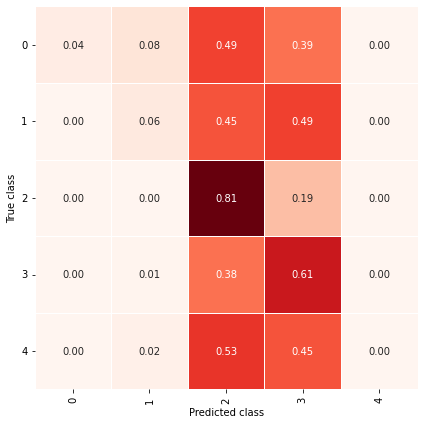

In [80]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()

plt.savefig('conf_matrix_100epoch_SGD_DropOut.jpg')
plt.show()

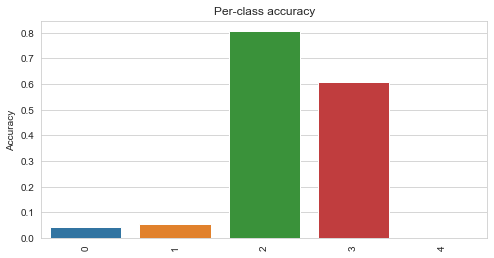

In [81]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.savefig('class_prob_100epoch_SGD_DropOut.jpg')
    plt.show()